In [549]:
%matplotlib inline
from __future__ import print_function
import numpy
import numpy.fft as fft
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.collections
import matplotlib.colors
import operator
import scipy
from functools import reduce

#### Overview: 

This final project compares the chebyshev spectral method and the second order centered finite difference method by solving the Poisson's equation.

# Comparing the Chebyshev spectral method and the second order second derivative approximation via the Poisson's equation

#### Introduction to Poisson's equation: 

We will solve the one-dimensional version of Poisson's equation to compare the relative accuracies of a Chebyshev spectral method and a second order centered finite difference method. Poisson's equation is an elliptic partial differential equation of broad utility in theoretical physics. For example, the solution to Poisson's equation is the potential field caused by a given electric charge or mass density distribution; with the potential field known, one can then calculate electrostatic or gravitational (force) field. $^{[3]}$ It is a generalization of Laplace's equation, which is also frequently seen in physics. The equation is named after French mathematician and physicist Siméon Denis Poisson.

#### Derivation of Poisson's equation:

A derivation of the Poisson's equation can be derived from Gauss' Law. $^{[3]}$

$$\nabla \cdot D = \frac{\rho}{\epsilon_r\epsilon_0}$$

Where $\nabla \cdot E$ is the divergence of the electric field, $\rho$ is the volume charge density, and the $\epsilon$ are experimentally determined physical constants. $^{[4]}$ Next, we apply the relationship 

$$E=\nabla V$$

leading to 

$$\nabla \cdot \nabla V=\frac{\rho}{\epsilon_r\epsilon_0}.$$

This is the Poisson's equation. In Cartesian coordinates, we have 

$$\nabla\cdot \nabla = \Big(\frac{\partial}{\partial x}+\frac{\partial}{\partial y}+\frac{\partial}{\partial y}\Big)\cdot\Big(\frac{\partial}{\partial x}+\frac{\partial}{\partial y}+\frac{\partial}{\partial y}\Big) $$

$$=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial y^2} =\nabla^2,$$

The operator $\nabla^2$ or $\Delta$ is named the Laplacian operator. In the more general form, the laplace equation is 

$$\Delta u = f$$ 

where $u$ and $f$ are real or complex valued functions on a manifold. Usually $f$ is given and $u$ is sought. Poisson's Equation is an inhomogeneous differential equation due to the right side function $f$ being nonzero. In the case of $f=0$, the equation reduces to a Laplace equation $^{[5]}$. 

In 1 spatial dimension, Poisson's equation becomes an ODE

$$u''(x)=f(x),$^{[5]}$$$

which is directly integrable to obtain the general solution

$$u(x)= \int\int f(x)dx.$$

We will consider a boundary value problem over the domain $[-1,1]$ with the boundary condition $u(-1,t)=u(1,t)=0$. 

$$u''(x)=e^{5x}$$

$$\begin{align}u(x)=&\int\int e^{5x}dx\\
=& \frac{e^{5x}}{25}+c_1x+c_2
\end{align}$$

The constants are determined by plugging in the boundary conditions

$$\begin{align}c_2&=-\frac{e^{10}+1}{50e^5}=-\frac{\cosh(5)}{25} 
\\c_1 &=-\frac{e^10-1}{2e^5}=-\frac{\sinh(5)}{25} \end{align}.$$

And so the solution is

$$u(x)=\frac{e^{5x}-x\sinh(5)-\cosh(5)}{25},$$

which will serve as a testing standard for the two methods. 


### Derivation the finite difference method

To derive the centered difference method for solving the one-dimensional Poisson's equation, we reduce the domain into $m$ evenly spaced points, called a mesh $^{[10]}$. We approximate the unknown function $u$ as the mesh points on the mesh points $x_i$. And we relate the number of mesh points $m$ to the distance between them with

$$\Delta x = \frac{1}{m + 1}.$^{[1]}$$$

The mesh points can be written as
 
$$x_i = a + i \Delta x.$^{[9]}$$$

We write $U_i$ to denote the approximate solution at the grid points $x_i$ and retain the lower-case $u(x)$ to denote the true solution. We apply the 2nd order, centered difference approximation for the 2nd derivative  

$$D^2 U_i = \frac{1}{\Delta x^2} (U_{i+1} - 2 U_i + U_{i-1}),^{[1]} $$

so that we end up with the approximate algebraic expression at every grid point $^{[1]}$

$$\frac{1}{\Delta x^2} (U_{i+1} - 2 U_i + U_{i-1}) = f(x_i) \quad i = 1, 2, 3, \ldots, m.$$

Notice that each $U_i$ depends on its neighbor $U_{i+1}$ and $U_{i-1}$, and so the equations for the $U_i$ are coupled. This means we can solve the $U_i$ as a system of equations $^{[1]}$

$$A U = F.$$

Where the matrix $A$ the approximated solution $U$, and the right hand side $F$ is 

$$\frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) - \frac{\alpha}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{\beta}{\Delta x^2} \\
    \end{bmatrix}.^{[2]}$$

Note that the boundary points $U_0$ and $U_{-1}$ since they cannot be computed from each other, and are dealt with by subtracting the two terms from the first and last row of $F$ $^{[1]}$. And for our problem, the additional terms are zero since $\alpha =\beta = 1$. 

In [557]:
##### the function to compute the second order centered difference approximation solution to the Poisson equation #####

def Centered_difference(a,b,m,f):
    ''' Solves the Poisson equation with zero boundary conditions given a function $f$. 
    Inputs 
        a: float. left boundary point
        b: float. right boundary point
        m: integer. determines the number of grid points on which to approximate U
        f: function. the right hand side of the function
    Outputs
        U: the solution evaluated on the grid points
    '''
    x_bc = numpy.linspace(a, b, m + 2)
    x = x_bc[1:-1]
    delta_x = (b - a) / (m + 1)

    # Construct matrix A
    A = numpy.zeros((m, m))
    diagonal = numpy.ones(m) / delta_x**2
    A += numpy.diag(diagonal * -2.0, 0)
    A += numpy.diag(diagonal[:-1], 1)
    A += numpy.diag(diagonal[:-1], -1)

    # Construct RHS
    b = f(x)
    b[0] -= u_a / delta_x**2
    b[-1] -= u_b / delta_x**2

    # Solve system
    U = numpy.empty(m + 2)
    U[0] = u_a
    U[-1] = u_b
    U[1:-1] = numpy.linalg.solve(A, b)
    
    return x_bc, U


#### Soution to the Poisson equation using the second order centered difference method:

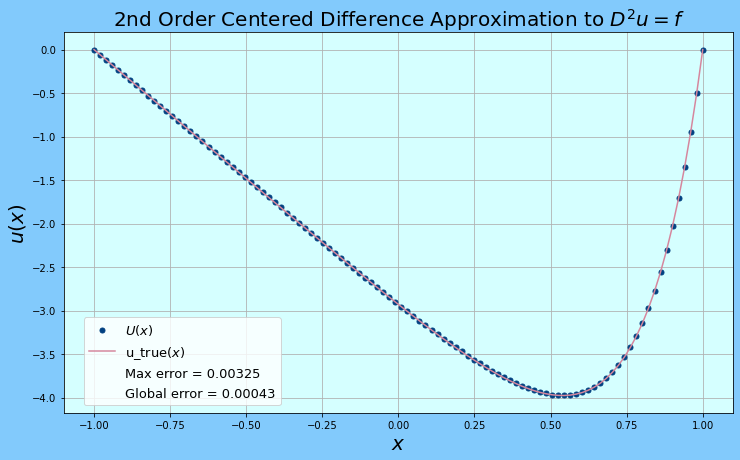

In [558]:
##### implement the finite differences function to solve the Poisson problem #####

# Problem setup
a = -1
b = 1.0
u_a = 0.0
u_b = 0
f = lambda x: numpy.exp(5*x)
u_true = lambda x: (numpy.exp(5.0 * x) - x * numpy.sinh(5.0) - numpy.cosh(5.0)) / 25.0
m = 100

# compute the solution and the infinity norm error
x_bc, U = Centered_difference(a,b,m,f)
error = numpy.linalg.norm(U - u_true(x_bc), ord=numpy.infty)

# compute the global error
delta_x = x_bc[1] - x_bc[0]
error2 = delta_x * numpy.linalg.norm(U - u_true(x_bc), ord=2)

# Plot result
fig = plt.figure(figsize=(12,7))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', color = 'xkcd:darkish blue',label="$U(x)$", markersize = '5')
axes.plot(x_bc, u_true(x_bc), 'k', color = 'xkcd:dull pink', label="u_true$(x)$")
axes.set_xlabel("$x$", fontsize= 20)
axes.set_ylabel("$u(x)$", fontsize= 20)
axes.grid(True)
plt.plot([], [], ' ', label="Max error = %s" % round(error,5))
plt.plot([], [], ' ', label="Global error = %s" % round(error2,5))
fig.patch.set_facecolor('xkcd:sky')
axes.set_facecolor("xkcd:very light blue")
axes.set_title(label = "2nd Order Centered Difference Approximation to $D^2u=f$", fontsize = 20)
plt.legend(loc = (0.03,.02), fontsize = 13)
plt.show()

*__Figure 1:__ Finite difference solution and the true solution to $u(x)''=f(x)$. The blue circles are the approximated solution, and the burgandy line represents the analytical solution. The maximum error represents the error in the infinity norm, $||E||_\infty$. The global error represents the error in the standard Euclidean norm, $||E||_2$.*

#### Analysis of figure 1: 
The max error of the 2nd order centered difference approximation was $.00325$, and the global error was $.00043$. The relative sizes of the errors match the expectations, as the maximum error should be smaller than the 2-norm of all the errors $U_i-u(x_i)$. And from a visual perspective, the approximated solution matches up nicely with the true solution with relatively little deviance. The number of mesh points used here was $101$.




### The Chebyshev Spectral Method

##### Chebyshev Differentiation

We use polynomials to interpolate the function using interpolation points that are distributed such that 

$$x_j = \cos\left(\frac{j \pi}{N} \right), \quad j=0, 1, \ldots, N,^{[6]}$$

called the Chebyshev points of the second kind $^{[2]}$. One way we can derive finite differences is by interpolating a polynomial through the stencil points and taking the derivative of the resulting interpolant. We can do the same thing to find Chebyshev differentiation matrices. Since any interpolant is unique based on the points it passes through we just need to determine the derivative based on the Chebyshev nodes themselves $^{[12]}$.

Let 

$$p_N(x_j) = v_j, \quad 0 \leq j \leq N$$

be the polynomial of degree $N$, then the resulting derivative is

$$p'_N(x_j) = w_j.^{[12]}$$

Since this operation is linear we can form this as multiplication by a matrix:

$$\mathbf{w} = \mathbf{D}_N \mathbf{v}$$

In general the Chebyshev differentiation matrices take the form

$$\begin{aligned}
    (D_N)_{00} = \frac{2 N^2 + 1}{6}, & & (D_N)_{NN} = -\frac{2N^2 + 1}{6}, \\
    (D_N)_{jj} = \frac{-x_j}{2(1 - x_j^2)}, & & j=1,\ldots,N-1 \\
    (D_N)_{ij} = \frac{c_i(-1)^{i+j}}{c_j (x_i - x_j)}, & & i\neq j, ~~ i,j = 0, \ldots, N
\end{aligned}$^{[2]}$$

where 

$$c_i = \left \{ \begin{aligned}
        2, & & i=0 \text{ or } N \\
        1, & & \text{otherwise}.
    \end{aligned} \right .^{[2]}$$$

And we are able to take a second derivative using this matrix $D$, by operating iteratively on $U$ twice

$$D^2_N U \approx \frac{d^2}{dx^2}u(x_i).^{[14]}$$

This allows us to solve Poisson's equation, as a set of equations for the $U_i$s approximated at the Chebyshev nodes $x_i^{[14]}$

$$D^2_N U = F$$

$$\Longrightarrow U = (D^n_N)^{-1}F.^{[13]}$$
 
 
 

In [559]:
import warnings
warnings.filterwarnings('ignore')

def cheb(N):
    '''Takes as input an integer N and returns a set of Chebyshev nodes on the domain -1<x<1
    and the Chebyshev differentiatoin matrix for computing the second derivative of U
        Inputs
            N : the number of Chebyshev nodes 
        Outputs
            D : the Chebyshev differentiation matrix with N+1 rows and columns
            x : the Chebychev nodes
    '''
    x = numpy.cos(numpy.pi * numpy.arange(N+1) / N)
    e = scipy.ones((N + 1, 1))
    Xdiff = scipy.outer(x, e) - scipy.outer(e, x) + scipy.identity(N + 1)
    xprod = -reduce(operator.mul, Xdiff) # product of rows
    W = scipy.outer(1.0 / xprod, e)
    D = W / scipy.multiply(W.T, Xdiff)
    d = 1-sum(D)

    for k in range(0, N+1):  # Set diagonal elements
        D[k,k] = d[k]

    return -D.T, x

def cheb_poisson(N,f):
    ''' calls the function cheb and computes the solution to the Poisson boundary value problem given the function f.
        Inputs
            N: the number of Chebyshev nodes to interpolate the solution 
            f: the right side function of the Poisson equation 
        Outputs
            x: the N+1 Chebyshev nodes 
            U: the approximated solution to the Poisson equation on N+1 points
    '''
    # Compute square and remove boundaries
    D, x = cheb(N)
    D2 = numpy.dot(D, D)[1:-1, 1:-1]

    # Solve the problem
    U = numpy.zeros(N + 1)
    U[1:-1] = numpy.linalg.solve(D2, f(x[1:-1]))
    
    return x, U

#### Solution to the Poisson equation using the Chebyshev spectral method:

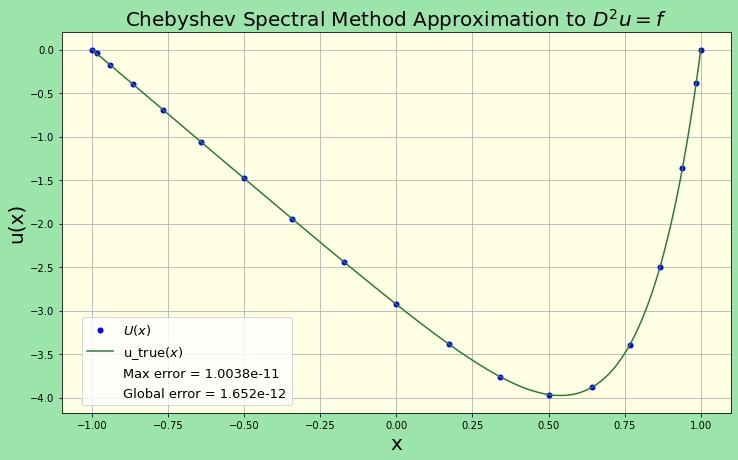

In [560]:
##### implement the chebyshev spectral method to solve Poisson's equation #####

#set up the problem 
f = lambda x: numpy.exp(5*x)
u_true = lambda x: (numpy.exp(5.0 * x) - x * numpy.sinh(5.0) - numpy.cosh(5.0)) / 25.0 
N = 18
x_fine = numpy.arange(-1, 1.01, 0.01)

#compute the solution and the infinity norm error
x, U = cheb_poisson(N,f)
error = numpy.linalg.norm(U - u_true(x), ord = numpy.infty)

#compute the global error by looping through the N spaces between the Chebyshev nodes
er = []
for i in range(N):
    delta_x = x[i+1] - x[i]
    e = numpy.abs(u_true(x[i+1]) - U[i+1])
    e = delta_x * e
    er.append(e)
error2 = float(numpy.linalg.norm(er))

# Plot the results
fig = plt.figure(figsize=(12,7))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'o', color='b', label = '$U(x)$', markersize = '5')
axes.plot(x_fine, u_true(x_fine), color = 'xkcd:darkish green', label='u_true$(x)$')
axes.set_xlabel('x', fontsize = 20)
axes.set_ylabel('u(x)', fontsize = 20)
axes.grid(True)
plt.plot([],[],' ', label = "Max error = %s" % round(error,15))
plt.plot([],[],' ', label = "Global error = %s" % round(error2,15))
fig.patch.set_facecolor('xkcd:hospital green')
axes.set_facecolor('xkcd:off white')
axes.set_title(label = 'Chebyshev Spectral Method Approximation to $D^2u=f$', fontsize = 20)
plt.legend(loc = (0.03,.02),fontsize=13)
plt.show()


*__Figure 2:__ The Chebyshev spectral method computed solution and the true solution to $u(x)''=f(x)$. The blue circles are the approximated solution, and the green line represents the analytical solution. As before, the maximum error represents the error in the infinity norm, $||E||_\infty$, and the global error represents the error in the standard Euclidean norm, $||E||_2$. The $N$ used here was $18$*

#### Analysis of Figure 2: 
The max error of the Chebyshev approximation was $1.038\times 10^{-11}$, and the global error (the error in the 2-norm times delta_x) was $1.652\times 10^{-12}$.* The error numbers of the Chebyshev spectral method are around $7$ orders of magnititude smaller than the error numbers of the finite difference method, despite the former method using less than $1/5$ of the interpolation points. And visually speaking, the approximated solution matches up nicely with the true solution. 


Visually, the approximated solution matches the true solution.

### Numerical Error analysis 

We use a norm that contains the grid width $\Delta x$, known as grid function norms, to analyze the error$^{[8]}$. 

$$ ||E||_2 = \left( \Delta x \sum^m_{i=1} |E_i|^2 \right )^{1/2} $$

This is known as the global error. We are interested in understanding how this global error behaves when we change $\Delta x$. 

We also use a norm that computes the maximum error $U_i-\text{u_true}(x_i)$, known as the infinity norm error$^{[8]}$.

$$ ||E||_\infty = \max_{1 \leq i \leq m} |E_i| = \max_{1 \leq i \leq m} |U_i - u(x_i)|$$

We know that if $||E||_\infty$ goes to zero as $\Delta x\rightarrow 0$, then we can claim that the approximation at any of the grid points goes to zero. 



### Comparison of the accuracies of the finite difference method and the Chebyshev spectral meethod:

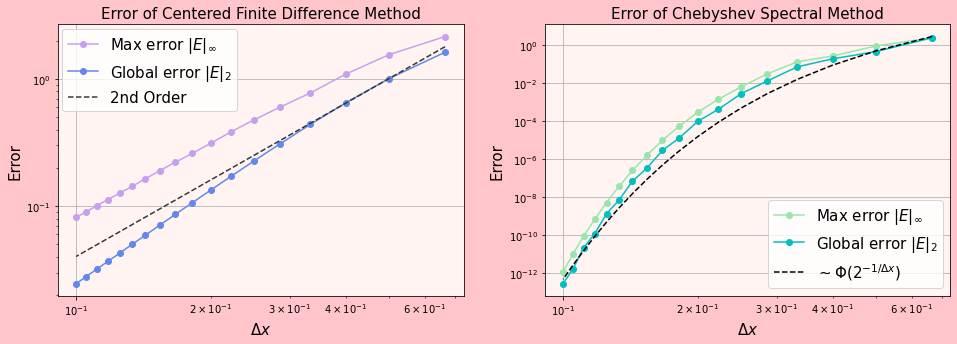

In [561]:
##### Compare accuracies of  finite difference and Chebyshev #####

#### implement the two methods to solve the Poisson problem ####
# Problem setup
a = -1
b = 1.0
u_a = 0.0
u_b = 0
f = lambda x: numpy.exp(5*x)
u_true = lambda x: (numpy.exp(5.0 * x) - x * numpy.sinh(5.0) - numpy.cosh(5.0)) / 25.0

#define the number of N or n to use
num_steps = [n for n in range(2, 20)]

#initialize arrays
error_finite_i = numpy.empty(len(num_steps))
error_finite_g = numpy.empty(len(num_steps))
error_cheb_i = numpy.empty(len(num_steps))
error_cheb_g = numpy.empty(len(num_steps))
delta_x = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    m = N
    # compute the finite difference infinity norm errors
    x_bc, U = Centered_difference(a,b,m,f)
    error_finite_i[i] = numpy.linalg.norm(U - u_true(x_bc), ord=numpy.infty)
    
    # compute the finite difference global errors
    delta_x[i] = x_bc[1] - x_bc[0]
    error_finite_g[i] = delta_x[i] * numpy.linalg.norm(U - u_true(x_bc), ord=2)
    
    #compute the chebyshev infinity norm errors
    x, U = cheb_poisson(N,f)
    error_cheb_i[i] = numpy.linalg.norm(U - u_true(x), ord = numpy.infty)

    #compute the chebychev global error by looping through the N spaces between the Chebyshev nodes
    er = []
    for j in range(N):
        delta_x_temp = x[j+1] - x[j]
        e = numpy.abs(u_true(x[j+1]) - U[j+1])
        e = delta_x_temp * e
        er.append(e)
    error_cheb_g[i] = float(numpy.linalg.norm(er))

# Plot error vs. delta_t
fig = plt.figure(figsize= (8,5))
fig.set_figwidth(fig.get_figwidth() * 2)
fig.patch.set_facecolor('xkcd:light rose')

axes = fig.add_subplot(1, 2, 1)

axes.loglog(delta_x, error_finite_i, marker ='o', color = 'xkcd:lavender', label='Max error $|E|_\infty$')
axes.loglog(delta_x, error_finite_g, marker ='o', color = 'xkcd:soft blue', label='Global error $|E|_2$')
order_C = lambda delta_x, error_finite_g, order: numpy.exp(numpy.log(error_finite_g) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[1], error_finite_g[1], 2.0) * delta_x**2.0, '--', color ='xkcd:dark grey', label="2nd Order")
axes.legend(loc=(.01,.68), fontsize = 15)
axes.grid(True)
axes.set_title("Error of Centered Finite Difference Method", fontsize = 15)
axes.set_xlabel("$\Delta x$", fontsize = 15)
axes.set_ylabel("Error", fontsize = 15)
axes.set_facecolor('xkcd:very light pink')

axes = fig.add_subplot(1, 2, 2)

exp = lambda x: 2**(-5/x+9)

axes.loglog(delta_x, error_cheb_i, marker ='o', color = 'xkcd:hospital green', label='Max error $|E|_\infty$')
# order_C = lambda delta_x, error_cheb_i, order: numpy.exp(numpy.log(error_cheb_i) - order * numpy.log(delta_x))
axes.loglog(delta_x, error_cheb_g, marker ='o', color = 'c', label='Global error $|E|_2$')
# axes.loglog(delta_x, order_C(delta_x[1], error_cheb_i[1], 2.0) * delta_x**2.0, 'k--', label="2nd Order")

axes.grid(True)
axes.loglog(delta_x, exp(delta_x), 'k--' ,label = '$\sim \Phi(2^{-1/ \Delta x})$')
axes.legend(loc=(.55,.03), fontsize = 15)
axes.set_title("Error of Chebyshev Spectral Method" , fontsize = 15)
axes.set_xlabel("$\Delta x$", fontsize = 15)
axes.set_ylabel("Error", fontsize = 15)
axes.set_facecolor('xkcd:very light pink')

plt.show()

*__Figure 3: __ Comparison of the accuracies of the finite difference method and the Chebyshev spectral method. __Left figure:__ The convergence behaviors of the maximum and global errors of the finite difference method on the logarithmic scale. The horizontal axis represents $\log\Delta x$ and the vertical axis represents $\log{\text{error}}$. The light purple line is the maximum error, the blue line is the global error, and the dotted black line is the indicator of second order convergence behavior.  __Right figure:__ The convergence bahaviors of the max and global errors of the Chebyshev spectral method. The horizontal axis represents $\log\Delta x$ and the vertical axis represents $\log{\text{error}}$. The light green line is the maximum error and the turquoise line is the global error, there is no convergence order indicator unlike with the finite difference method. Instead the dotted black line represents a function that behaves as $2^{-N}$ for large $N$. The $\Delta x$ used in creating this numerical analysis are such that $\frac{1}{10} \leq \Delta x \leq 1$.*

#### Analysis of Figure 3: 
For the finite difference method, the maximum and global errors differ from each other by around 1 order of magnitude, with the clobal error being less than the maximum error for a given $\Delta x$ as expected. The logarithmic scale allows the display of convergence behavior in a linear fashion, and the figure shows that both the maximum and minimum errors converge as second order, as expected. And on the other hand, the Chebyshev spectral method's error decreases exponentially with decreasing $\Delta x$. The Chebyshev method does not have a linear indicator of the order of convergence that depends on $\Delta x$. Instead, the methos has a convergence behavior that goes as $2^{-1/\Delta x}$. With $2$ grid points, both methods have similar accuracies. And at $20$ grid points, the Chebyshev spectral method has around $10-11$ orders of magnitude smaller errors than the finite difference method, which is a relatively drastic change. It is worth mentioning that the Chebyshev method does not have equidistant grid points, because the grid points are the roots of the Chebychev polynomials. And so, in order to study the convergence behavior with decreasing $\Delta x$, the global error for this method was calculated by taking the square root of the square of the sum of the individual errors $|U_i-u(x_i)|$, weighted by the $\Delta x_i=x_{i}-x_{i-1}$. And however, the $Delta x$ that is used on the horizontal axis is simply computed by dividing 1 by the total number of grid points, and not computed from the actual distances between the Chebyshev nodes. This simplification was made to compare the convergence behavior of the spectral method with the finite difference method.

### Behavior of the the solutions as $f$ changes with time:

The goal is to examine the consistency of the methods by changing $f$ and see how stable the errors are. We will do this by making $f$ vary with time, and computing the error at varying times.

Let 

$$f= (t^3-1)e^x$$

and 

$$u''(x)=(t^3-1)e^x.$$

The true solution is 

$$ u(x)=c_1+c_2x+(t^3-1)e^x$$

with 

$$c_1=-\frac{1}{2}(t^3-1)(\frac{1}{e}+e)\text{ and } c_2 = -(t^3-1)e-c_2.$$

### The finite difference method:


t = 0:
global error = 2.628339e-06
t = 0.5:
global error = 2.299797e-06
t = 1:
global error = 0.0
t = 1.5:
global error = 6.242306e-06
t = 2:
global error = 1.8398376e-05
t = 2.5:
global error = 3.8439464e-05
t = 3:
global error = 6.8336824e-05
t = 3.5:
global error = 0.000110061712
t = 4:
global error = 0.000165585382
t = 4.5:
global error = 0.000236879088


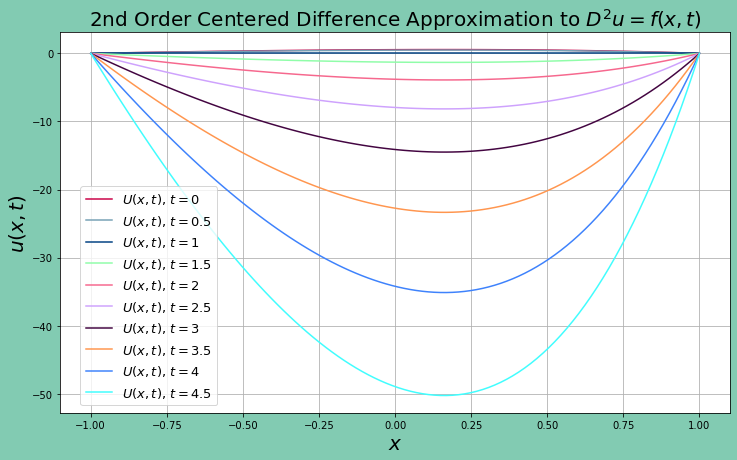

In [576]:
##### implement the finite differences function to solve the Poisson problem #####

# Problem setup
a = -1
b = 1.0
u_a = 0.0
u_b = 0
m = 100

# Plot result
fig = plt.figure(figsize=(12,7))
axes = fig.add_subplot(1, 1, 1)

colors = ['xkcd:ruby','xkcd:greyblue','xkcd:darkish blue','xkcd:foam green', 'xkcd:rosy pink', 'xkcd:lilac', 'xkcd:eggplant purple', 'xkcd:pastel orange', 'xkcd:dodger blue', 'xkcd:bright cyan']
for (n,t) in enumerate([0,.5,1,1.5,2,2.5,3,3.5,4,4.5]):
    
    f = lambda x: (t**3 - 1) * numpy.exp(x)
    c_1 = (-(t**3-1)/2) * (1/numpy.exp(1) + numpy.exp(1))
    c_2 =  -(t**3 - 1) * numpy.exp(1) - c_1
    u_true = lambda x: c_1 + x * c_2 + (t**3 - 1) * numpy.exp(x)


    # compute the solution 
    x_bc, U = Centered_difference(a,b,m,f)

    # compute the global error
    delta_x = x_bc[1] - x_bc[0]
    error2 = delta_x * numpy.linalg.norm(U - u_true(x_bc), ord=2)
    print('t = {}:'.format(t))
    print("global error = %s" % round(error2,12))
    axes.plot(x_bc, U, '-', color = colors[n] ,label="$U(x,t)$, $t={}$".format(t), markersize = '5')

axes.set_xlabel("$x$", fontsize= 20)
axes.set_ylabel("$u(x,t)$", fontsize= 20)
axes.grid(True)

fig.patch.set_facecolor('xkcd:pale teal')
axes.set_facecolor("xkcd:white")
axes.set_title(label = "2nd Order Centered Difference Approximation to $D^2u=f(x,t)$", fontsize = 20)
plt.legend(loc = (0.03,.02), fontsize = 13)
plt.show()


*__Figure 4:__ Finite difference solutions to $u''(x)=te^x)$ with $t\in\{0,.5,1,1.5,2,2.5,3,3.5,4,4.5\}$. This figure shows the approximated solutions at various times, with $101$ grid points. Printed above the figure are the global error at varying times.*

#### Analysis of the figure and the error results:
As expected, the finite difference method's global error bottoms out when $t=0$, and the true solution is  $u(x)=c_1+c_2x$, with constant coefficients $c_1$ and $c_2$. This fits our expectations because the finite difference method should have zero error when approximating a linear solution, since the method approximates the second derivative at each point $x_i$ using a linear expression of the $U(x_i), U(x_{i+1})$, and $U(x_{-1})$. And furthermore, the error becomes progressively worse as the average curvature at the points $x_i$ increases, as expected. The error at $t=4.5$ is around 2 times larger in magnitude than the error at $t=.5$.

#### The Chebyshev spectral method:

t = 0:
global error = 0.01918777549009484
t = 0.5:
global error = 0.016789303553832995
t = 1:
global error = 0.0
t = 1.5:
global error = 0.045570966788975216
t = 2:
global error = 0.13431442843066396
t = 2.5:
global error = 0.2806212165426364
t = 3:
global error = 0.4988821627424673
t = 3.5:
global error = 0.803488098647724
t = 4:
global error = 1.208829855875977
t = 4.5:
global error = 1.7292982660447993


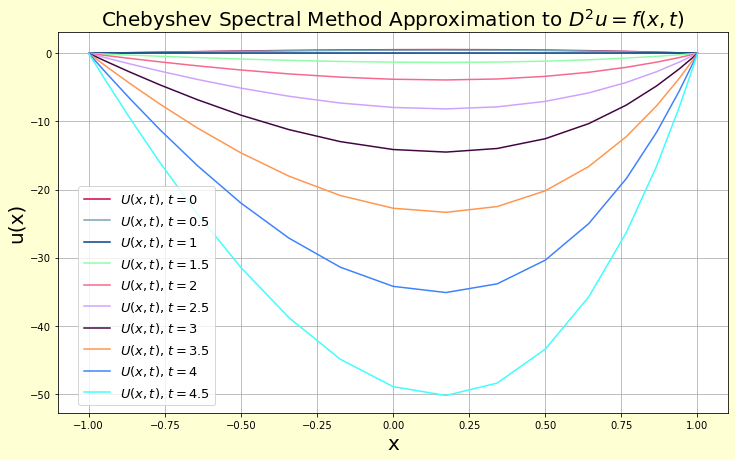

In [577]:
##### implement the chebyshev spectral method to solve Poisson's equation #####

#set up the problem 
N = 18
x_fine = numpy.arange(-1, 1.01, 0.01)


# Plot result
fig = plt.figure(figsize=(12,7))
axes = fig.add_subplot(1, 1, 1)

colors = ['xkcd:ruby','xkcd:greyblue','xkcd:darkish blue','xkcd:foam green', 'xkcd:rosy pink', 'xkcd:lilac', 'xkcd:eggplant purple', 'xkcd:pastel orange', 'xkcd:dodger blue', 'xkcd:bright cyan']
for (n,t) in enumerate([0,.5,1,1.5,2,2.5,3,3.5,4,4.5]):
    
    f = lambda x: (t**3 - 1) * numpy.exp(x)
    c_1 = (-(t**3-1)/2) * (1/numpy.exp(1) + numpy.exp(1))
    c_2 =  -(t**3 - 1) * numpy.exp(1) - c_1
    u_true = lambda x: c_1 + x * c_2 + (t**3 - 1) * numpy.exp(x)


    #compute the solution 
    x_bc, U = cheb_poisson(N,f)
    
    #compute the global error by looping through the N spaces between the Chebyshev nodes
    er = []
    for i in range(N):
        delta_x = x[i+1] - x[i]
        e = numpy.abs(u_true(x[i+1]) - U[i+1])
        e = delta_x * e
        er.append(e)
    error = float(numpy.linalg.norm(er))
    print('t = {}:'.format(t))
    print("global error = %s" % error)
    
    axes.plot(x_bc, U, '-', color = colors[n] ,label="$U(x,t)$, $t={}$".format(t), markersize = '5')

axes.set_xlabel('x', fontsize = 20)
axes.set_ylabel('u(x)', fontsize = 20)
axes.grid(True)
fig.patch.set_facecolor('xkcd:eggshell')
axes.set_facecolor('xkcd:white')
axes.set_title(label = 'Chebyshev Spectral Method Approximation to $D^2u=f(x,t)$', fontsize = 20)
plt.legend(loc = (0.03,.02),fontsize=13)
plt.show()

*__Figure 5:__ Chebyshev spectral method solutions to $u''(x)=te^x)$ with $t\in\{0,.5,1,1.5,2,2.5,3,3.5,4,4.5\}$. This figure shows the approximated solutions at various times, with $17$ grid points. Printed above the figure are the global errors at varying times.*

#### Analysis of the figure and the error results:
As expected, the Chebyshev spectral method's global error also bottoms out at $t=0$, when the solution becomes linear. This fits our expectations because the Chebyshev spectral difference method should have zero error when approximating a linear solution, since the linear function is the second of the Chebyshev polynomials. Furthermore, the error has a positive dependence on the average curvature of the solution, where the error at $t=4.5$ has around a 2 times larger magnitude than the error at $t=.5$. 




## Convergence analysis
#### Derivation of the local truncation error for the finite difference method:

The algebraic equations are an approximation to the original boundary value problem, and so the true solution will not exactly satisfy these equations, the difference between the $U_i$ and $u(x_i)$ is called the local truncation error $\tau$.

For our centered finite difference approximation, we have

$$\frac{1}{\Delta x^2} (U_{i+1} - 2 U_i + U_{i-1}) = f(x_i).^{[7]}$$

Replacing $U_i$ with $u(x_i)$ in this equation leads to

$$\tau_i = \frac{1}{\Delta x^2} (u(x_{i+1}) - 2 u(x_i) + u(x_{i-1})) - f(x_i).^{[7]}$$

We assume $u(x)$ is smoooth, and replace the $u(x_i)$ with their Taylor series counterparts. 

The relevant Taylor series are 

$$u(x_{i \pm 1}) = u(x_i) \pm u'(x_i) \Delta x + \frac{1}{2} u''(x_i) \Delta x^2 \pm \frac{1}{6} u'''(x_i) \Delta x^3 + \frac{1}{24} u^{(4)}(x_i) \Delta x^4 + \mathcal{O}(\Delta x^5)^{[8]}$$

which leads to an expression for the local truncation error, $\tau_i$ of 

$$\begin{aligned}
    \tau_i &= \frac{1}{\Delta x^2} \left [u''(x_i) \Delta x^2 + \frac{1}{12} u^{(4)}(x_i) \Delta x^4 + \mathcal{O}(\Delta x^5) \right ] - f(x_i) \\
    &= u''(x_i) + \frac{1}{12} u^{(4)}(x_i) \Delta x^2 + \mathcal{O}(\Delta x^4) - f(x_i) \\
    &= \frac{1}{12} u^{(4)}(x_i) \Delta x^2 + \mathcal{O}(\Delta x^4)^{[1]}
\end{aligned},$$

which indicates the method is 2nd order accurate. And as long as $u^{(4)}(x_i)$ remains finite (smooth), we know that $\tau_i\rightarrow 0$ as $\Delta x\rightarrow 0$.$^{[1]}$ And so the convergence depends on $\Delta x$. These results match well with the numerical results found in the previous part, because we found in both cases that this method is 2nd order accurate in space.


#### Factors that contribute to the accuracy of the Chebyshev spectral method:

One way to analyze the accuracy of the Chebyshev spectral method is to gauge the Chebyshev nodes' optimality as a set of interpolation points. Consider the Lebesgue function

$$\lambda_N(x)  = \sum_{i=0}^N\big{|}\ell_i(x)\big{|}^{[2]}$$

Where $\ell_i(x)$ are Lagrange basis functions for a given set of $x_i$. the maximum of the Lebesque function is called $\Lambda_n$, the Lebesque constant and are clearly related to Lagrangian interpolation as they provde a first estimate for the interpolation error. Unfortunately, $\Lambda_N$ is not uniformly bounded regardless of the nodes used as one can show that 

$$\Lambda_N > \mathcal{O}(\log N) \quad \text{as} \quad N \rightarrow \infty^{[2]}$$

To actually show that the Chebyshev nodes are optimal consider the monic polynomial $p(z)$  in the complex plane of degree $N$

$$p(z) = \prod^N_{k=1} (z - z_k)^{[2]}$$

where $z_k$ are the roots with possible non-trivial multiplicity. Manipulating this a bit we can also write the related expressions

$$\begin{aligned}
    |p(z)| &= \prod^N_{k=1} |z - z_k| \\
    \log|p(z)| &= \sum^N_{k=1} \log|z - z_k|.
\end{aligned}^{[2]}$$

Let 

$$\phi_N(z) = \frac{1}{N} \sum^N_{k=1} \log |z - z_k|,^{[2]}$$

since $\phi_N(z)$ is harmonic it satisfies Laplace's equation in the complex plane except at the roots $z_k$. This setup can be viewed as an electrostatic potential with charges at the roots $z_k$. The potential from each of the charges is

$$\frac{\log |z - z_k|}{N}.^{[2]}$$.

Consider now the relationship between $|p(z)|$ and $\phi_N(z)$. From our previous expressions we know that

$$|p(z)| = e^{N \phi_N(z)}.^{[2]}$$

If $\phi_N(z)$ is roughly constant on the interval $[-1,1]$ then $|p(z)|$ is as well. If on the other hand $\phi_N(z)$ varies then the variation of $|p(z)|$ will be exponential, especially with large $N!$, With an eye towards this behavior consider the $N\rightarrow \infty$ limit and consider the points $x_j$ distributed in $[-1,1]$ according to a density function $p(x)$ with

$$\int^1_{-1} \rho(x) dx = 1.^{[2]}$$


From this density function we also know the number of grid points in an interval $[a,b]$ as

$$1 = N \int^b_a \rho(x) dx.^{[2]}$$

Using this framework we can write the potential as

$$\phi(z) = \int^1_{-1} \rho(x) \log |z - x| dx.^{[2]}$$

In the limit $N\rightarrow \infty$ we can show for equispaced points that

$$\phi(z) = -1 +\frac{1}{2} \Re((z + 1) \log(z + 1) - (z-1)\log(z-1)).^{[2]}$$

Note that $\phi(0)=-1$ and $\phi(\pm 1)=-1+\log 2$ which implies that if a polynomial $p$ has equispaced roots on $[-1,1]$ then it will take values that are $2^N$ larger near the points $\pm 1$ than near $0$.

Instead if we consider the distribution for the Chebyshev points

$$\rho(x) = \frac{1}{\pi \sqrt{1 - x^2}}, \quad x\in[-1,1]^{[2]}$$

we can show that the resulting potential is

$$\phi(z) = \log\frac{\left|z - \sqrt{z^2 - 1} \right |}{2}.^{[2]}$$

Interestingly these formula have a simple interpretation, the level curves of $\phi(z)$ are the ellipses with foci $\pm 1$. The value of $\phi(z)$ along any such ellipse is the logarithm of half the sum of the semimajor and minor axes of the ellipses. The degenerate ellipse $[-1,1]$ is a level curve as well and takes on the constant value $-\log 2$. This turns out to be optimal with the polynomial growing as

$$|p(z)| = e^{N \phi(x)} \approx 2^{-N}, ~~~ x\in[-1,1].^{[2]}$$

And so to summarize, the Chebyshev spectral method relies on interpolating $u(x)$ using Chebyshev polynomials at the unevenly spaced nodes, called Chebyshev roots, and the error decreases exponentially with increasing $N$ (or decreasing $\Delta x$.  This matches our previous results well, because we found numerically that the spectral method's error decreases exponentially with decreasing $\Delta x$.


# citations 

[1] Class notes: https://github.com/mandli/numerical-methods-pdes/blob/master/04_BVP_problems.ipynb

[2] Class notes: https://github.com/mandli/numerical-methods-pdes/blob/master/14_spectral.ipynb

[3] "Poisson equation", Encyclopedia of Mathematics, EMS Press, 2001 [1994]

[4] Poisson Equation at EqWorld: The World of Mathematical Equations

[5] Grant, I. S.; Phillips, W. R. (2008). Electromagnetism. Manchester Physics (2nd ed.). John Wiley & Sons. ISBN       978-0-471-92712-9.

[6] "Chebyshev interpolation: An interactive tour". Mathematical Association of America (MAA) – includes               illustrative Java applet.

[7] Christian Grossmann; Hans-G. Roos; Martin Stynes (2007). Numerical Treatment of Partial Differential Equations.     Springer Science & Business Media. p. 23. ISBN 978-3-540-71584-9.

[8] Arieh Iserles (2008). A first course in the numerical analysis of differential equations. Cambridge University      Press. p. 23. ISBN 9780521734905.

[9] Smith GD (1985). Numerical solution of partial differential equations: finite difference methods (3rd ed.). Oxford University Press.

[10] K.W. Morton and D.F. Mayers, Numerical Solution of Partial Differential Equations, An Introduction. Cambridge University Press, 2005.

[11] Peter Olver (2013). Introduction to Partial Differential Equations. Springer. Chapter 5: Finite differences. ISBN 978-3-319-02099-0..

[12] Mathews, John H. (2003). "Module for Chebyshev polynomials". Department of Mathematics. Course notes for Math      340 Numerical Analysis & Math 440 Advanced Numerical Analysis. Fullerton, CA: California State University.          Archived from the original on 29 May 2007. Retrieved 6 May 2023.

[13] Gottlieb, David; Orszag, Steven A. (1989). Numerical analysis of spectral methods : theory and applications (5. print. ed.). Philadelphia, Pa.: Society for Industrial and Applied Mathematics. ISBN 978-0898710236.


### Other resources used:

[1] Latex guide: https://www.cmor-faculty.rice.edu/~heinken/latex/symbols.pdf

[2] Numpy manual: https://numpy.org/doc/stable/index.html